In [109]:
#Import Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

pd.options.mode.chained_assignment = None  
pd.set_option('display.max_columns',80)  # or 1000
pd.set_option('display.max_rows', 100)  # or 1000

from sklearn import preprocessing


import ast #For converting string to list

import warnings
warnings.filterwarnings('ignore')

In [110]:
#Import dataset
df_raw = pd.read_csv('listings.csv')

#Checking Shape
print(f'{df_raw.shape[0]} examples, {df_raw.shape[1]} features')

# ... and duplicates
print("It contains {} duplicates.".format(df_raw.duplicated().sum()))


24551 examples, 106 features
It contains 0 duplicates.


In [111]:
# Deciding which columns to work with

#1 City, street, state are mostly same for all, id is unique and scrape_id is same for all.
#2 experiences_offered, thumbnail_url, medium_url are  empty
#3 picture_url, host_thumbnail_url, host_picture_url links are broken.

columns_to_discard = ['city','scrape_id','experiences_offered','thumbnail_url','medium_url',
                     'picture_url','xl_picture_url','host_acceptance_rate','host_thumbnail_url',
                     'host_picture_url','street','state','market','smart_location','country_code',
                     'country','has_availability','calendar_last_scraped','license','jurisdiction_names',
                     'is_business_travel_ready','host_name','square_feet',
                     'calendar_updated','host_id','zipcode']

#Columns with working link: Can be used for data scraping
linked_columns= ['listing_url','host_url']

#Columns that can be analyzed with NLP
text_columns = ['name','summary','space','description','neighborhood_overview',
               'notes','transit','access','interaction','house_rules','host_about']

#Date columns can be feature-engineered
date_columns = ['host_since','first_review','last_review',]

#Categorical columns (will be converted to categories)
cat_columns = ['last_scraped','host_response_time','host_response_rate','host_is_superhost',
              'host_neighbourhood','host_verifications','host_has_profile_pic','host_identity_verified',
              'neighbourhood','neighbourhood_cleansed','neighbourhood_group_cleansed','is_location_exact',
              'property_type','room_type','bed_type','amenities','calendar_updated','requires_license',
              'instant_bookable','cancellation_policy','require_guest_profile_picture',
               'require_guest_phone_verification']

target_column = 'price'

print(len(df_raw.columns),'total column count\n')
print(len(columns_to_discard), 'useless columns')
print(len(linked_columns),'columns with link included')
print(len(text_columns),'text columns')
print(len(date_columns),'date type columns')
print(len(cat_columns),' categorical columns')

106 total column count

26 useless columns
2 columns with link included
11 text columns
3 date type columns
22  categorical columns


### Notes:

* Interesting feature is text german or english
* Didn't understand host_listings_count and host_total_listings_count (will look more closely)
They are almost same (only 51 of them different from 24551)
* Zipcode should be investigated more (to understand the correlation between numbers and location
if there is any.)
* How bathrooms can be a decimal number like 2.5 =)
* Square_feet, weekly/monthly prices are mostly NaN
* What is the difference between minimum_nights vs minimum_minimum_nights (23748 of them are same)
* Interesting visualizations for review columns (Average is not 5 for example. So we may shift the average)
* host_neighbourhood can be processed as inside the city vs outside the city. (Need Berlin's neighbourhoods)


In [112]:
#Check if there is any nan value in price
print(df_raw.price.isna().sum())
print('Price data doesnt have any null, which means we can use the full dataset for prediction model')

0
Price data doesnt have any null, which means we can use the full dataset for prediction model


In [113]:
#Dropping useless columns
def drop_useless_columns(df):
    temp = df.copy()   
    temp= temp.drop(columns= columns_to_discard)
    
    print('shape of df:',temp.shape)
    print(len(columns_to_discard),'useless columns are dropped')
    
    return temp

df_raw = drop_useless_columns(df_raw)

shape of df: (24551, 80)
26 useless columns are dropped


In [114]:
#Dropping text columns ( will handle them seperately after)
def drop_text_columns(df):
    temp = df.copy()
    temp_columns = text_columns + linked_columns
    temp = temp.drop(columns = temp_columns)

    print('shape of df:',temp.shape)
    print(len(temp_columns),'text columns are dropped')
    
    return temp

df_raw = drop_text_columns(df_raw)

shape of df: (24551, 67)
13 text columns are dropped


## Preprocessing the Data


In [115]:
#Finding NaN values
def print_nan_counts(df):
    print('Column Name: NaN Count')
    print('-----------------------')
    for column in df.columns:
        if any(df[column].isna()):
            print(column,':' ,df[column].isna().sum())

print_nan_counts(df_raw)

Column Name: NaN Count
-----------------------
host_since : 51
host_location : 143
host_response_time : 10452
host_response_rate : 10452
host_is_superhost : 51
host_neighbourhood : 5186
host_listings_count : 51
host_total_listings_count : 51
host_has_profile_pic : 51
host_identity_verified : 51
bathrooms : 29
bedrooms : 19
beds : 31
weekly_price : 21248
monthly_price : 22175
security_deposit : 9624
cleaning_fee : 7280
first_review : 4328
last_review : 4328
review_scores_rating : 4819
review_scores_accuracy : 4845
review_scores_cleanliness : 4842
review_scores_checkin : 4864
review_scores_communication : 4847
review_scores_location : 4863
review_scores_value : 4866
cancellation_policy : 1
reviews_per_month : 4328


I decided to get rid of that 51 rows since in most of the columns they don't have any information. 6 columns are dropped.

In [116]:
#Get rid of that 51 empty rows:
df_raw = df_raw[df_raw['host_since'].isna() == False]

print('shape of df:',df_raw.shape)

shape of df: (24500, 67)


In [117]:
#intersection of two lists Return true if there is at least one intersection
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return len(lst3) != 0

In [118]:
#Categorize Host Location as Berlin, Outside of Berlin, Outside of Germany and Unknown
def categorize_host_location(df):
    
    temp = df.copy() 
    locations = []
    counter = 0
    words =['Germany','DE']

    for _,row in temp.iterrows():

        location = row['host_location']    
        location= str(location)
        word_list = location.split(', ')

        if 'Berlin' in word_list:
            locations.append('Berlin')

        elif intersection(words,word_list):
            locations.append('Outside-of-Berlin')
            
        elif word_list[0] =='nan':
            locations.append('Unknown')
        else:
            #print(location)
            locations.append('Outside of Germany')

    temp['host_location'] = locations       

    return temp


df_raw = categorize_host_location(df_raw)

In [119]:
#Categorize Host Neighbourhood get most popular 15 and labels others as "others"
def categorize_host_neighbourhood(df):
    temp = df.copy()
    popular_neighbourhoods = ['Neukölln', 'Prenzlauer Berg','Kreuzberg','Friedrichshain',
      'Mitte','Wedding','Schöneberg','Charlottenburg','Moabit',
      'Wilmersdorf','Pankow','Tempelhof','Rummelsburg','Weißensee','Tiergarten']
    
    hood_list=[]
    
    for hood in temp['host_neighbourhood']:
        if hood in popular_neighbourhoods:
            hood_list.append(hood)
        else:
            hood_list.append('other')
    
    temp['host_neighbourhood'] = hood_list
    
    return temp

df_raw = categorize_host_neighbourhood(df_raw)

In [120]:
#Replace NaN values with 0:
def replace_nan(df,column):
    temp = df.copy()
    temp[column] = temp[column].fillna('$0.00')
    
    return temp

#Probably they are not charging cleaning fee and security deposits that's why they are nan.
df_raw = replace_nan(df_raw,'cleaning_fee')
df_raw = replace_nan(df_raw,'security_deposit')

In [121]:
print_nan_counts(df_raw)

Column Name: NaN Count
-----------------------
host_response_time : 10401
host_response_rate : 10401
bathrooms : 29
bedrooms : 19
beds : 31
weekly_price : 21209
monthly_price : 22134
first_review : 4313
last_review : 4313
review_scores_rating : 4802
review_scores_accuracy : 4828
review_scores_cleanliness : 4825
review_scores_checkin : 4847
review_scores_communication : 4830
review_scores_location : 4846
review_scores_value : 4849
cancellation_policy : 1
reviews_per_month : 4313


I'm planning to use XgBoost for the model and since XgBoost has the capability of handling missing data during training.

In [122]:
def convert_prices_into_float(df):
    temp = df.copy()
    
    price_columns = ['price','weekly_price','monthly_price','cleaning_fee','security_deposit','extra_people']
    for column in price_columns:
        temp[column] = temp[column].str.replace('$','').str.replace(',', '').astype(float)
        
    return temp

df_raw= convert_prices_into_float(df_raw)

In [129]:
#Get rid of prices equal to 0 or more than 500:
df_raw = df_raw[(df_raw['price'] != 0)]
df_raw = df_raw[(df_raw['price'] < 500)]

print('shape of df:',df_raw.shape)

shape of df: (24348, 67)


In [130]:
def categorize_ordinal_columns(df):
    temp = df.copy()
    cleanup_nums = {"room_type": {"Entire home/apt": 1, "Private room": 2, "Shared room": 3},
                   "cancellation_policy": {"flexible": 1, "moderate": 2, "strict": 3,
                                           "strict_14_with_grace_period": 3, "super_strict_30": 4,
                                          "super_strict_60": 5},
                   "bed_type": {"Real Bed": 1, "Pull-out Sofa": 2, "Futon": 3, 'Couch': 4, 'Airbed': 5}}
    temp =temp.replace(cleanup_nums)
    
    return temp
df_raw = categorize_ordinal_columns(df_raw)

In [131]:
 def categorize_columns(columns,df):
        le = preprocessing.LabelEncoder()
        temp = df.copy()
        
        for feature in columns:
            temp[feature] = le.fit_transform(temp[feature])
            
        return temp

In [132]:
#Columns to categorize
col_to_cat= ['host_location','host_response_time','host_is_superhost',
             'host_neighbourhood','neighbourhood_cleansed',
             'neighbourhood_group_cleansed',
             'require_guest_phone_verification','require_guest_profile_picture',
             'instant_bookable','requires_license','is_location_exact',
             'host_has_profile_pic','host_identity_verified',
             'property_type','neighbourhood']

df_raw= categorize_columns(col_to_cat,df_raw)

In [133]:
#Create verification features:
def convert_string_to_list(string):
    return ast.literal_eval(string)

def create_verification_features(df):
    temp = df.copy()
    verifications = ['email','phone','facebook','reviews','government_id','selfie']
    
    temp.host_verifications = temp.host_verifications.apply(convert_string_to_list)

    for verification in verifications:
        temp[f'verification_{verification}'] = [True if verification in x else False for x in temp.host_verifications]
        
    temp.drop(columns=['host_verifications'],inplace=True)
        
    return temp

In [134]:
df_raw = create_verification_features(df_raw)

In [135]:
def categorize_amenities(df):
    temp = df.copy()
    #amenit_list= set()
    amenit_count = []
    for i,row in temp.iterrows():
        amenit_list= []
        for amenit in row['amenities'].split('{')[1].split('"'):
            if len(list(amenit)) !=1:
                #amenit = amenit.replace(',',' ')
                #amenit = amenit.replace('"',' ')
                amenit = amenit.replace(' ','')
                amenit = amenit.replace('}','')
                temp_list = amenit.split(',')     
                temp_list = [i for i in temp_list if i]
                amenit_list.extend(temp_list)
        #print(len(amenit_list))
        amenit_count.append(len(amenit_list))
                #amenit_list.update(temp_list)
    #print(amenit_list)

    temp['amenities_count'] = amenit_count
    temp.drop(columns = ['amenities'],inplace=True)
    
    return temp

In [136]:
#df_raw = categorize_amenities(df_raw)

In [137]:
def drop_percent(string):
    try:
        return int(string.replace('%',''))
    except:
        return np.nan

df_raw.host_response_rate = df_raw.host_response_rate.apply(drop_percent)

In [138]:
print('Columns with "object" type :')
[ column for column in df_raw.columns if df_raw[column].dtype == object ]

Columns with "object" type :


['last_scraped', 'host_since', 'amenities', 'first_review', 'last_review']

The last columns that I didnt preprocessed are date columns. For now, I would drop these to continue my analysis. After creating the pipeline this part can be use for feature engineering.

## Exploratory Data Analysis

In [139]:
df_raw1.reset_index(drop=True,inplace= True)

NameError: name 'df_raw1' is not defined

13
31
19
24
22
14
37
13
9
20
16
17
19
17
34
38
19
16
51
13
24
28
35
32
15
36
22
21
23
12
6
11
5
17
24
36
20
13
28
31
12
8
19
38
0
27
13
12
30
22
23
13
35
21
5
17
21
8
27
29
22
28
45
27
11
38
21
25
21
38
24
69
19
17
5
16
24
9
10
21
21
16
6
44
21
25
29
21
36
20
42
12
17
31
44
48
23
18
17
20
23
8
56
34
11
20
9
31
30
18
24
13
45
26
29
8
34
10
32
30
16
30
15
44
50
24
8
9
19
46
29
12
22
21
13
48
24
7
28
20
21
20
10
29
8
11
11
16
13
31
11
20
22
32
22
35
13
18
8
35
24
24
10
41
24
17
22
39
35
27
22
8
23
39
29
17
12
22
14
13
22
19
41
46
22
14
5
25
23
14
34
25
30
33
31
18
28
9
26
31
9
18
21
27
27
19
19
14
20
23
15
34
17
18
20
20
19
59
34
19
28
9
31
18
17
18
32
41
31
44
15
37
31
12
10
3
3
5
20
25
5
14
14
18
23
26
20
26
13
18
29
32
28
19
26
19
19
23
33
23
22
23
25
21
21
13
24
32
12
53
20
18
19
17
18
16
17
16
16
17
34
27
19
8
20
29
26
57
46
54
21
22
18
18
24
27
20
17
8
8
16
28
15
38
22
14
19
10
7
19
16
12
16
8
12
22
9
29
24
7
7
23
26
41
26
23
25
12
8
16
38
17
15
16
17
24
38
24
15
18
16
31
27
24
8
8


29
6
6
20
9
22
21
11
12
9
37
5
29
11
8
7
10
6
14
31
7
18
5
7
6
13
6
3
35
25
7
10
8
4
10
9
26
6
9
17
11
24
12
14
9
20
17
18
10
6
26
8
6
25
24
16
6
12
22
2
12
28
7
27
8
8
13
9
7
9
15
9
19
12
7
8
8
10
18
9
6
15
10
29
9
15
14
11
15
22
30
13
12
21
12
13
4
8
20
11
20
21
30
11
30
28
6
7
12
15
6
6
13
7
13
7
16
1
7
27
13
10
3
15
5
15
4
7
22
15
10
8
26
32
6
22
27
9
17
7
22
17
7
61
13
19
23
24
7
7
5
9
6
6
9
15
9
7
25
27
7
10
8
7
6
8
16
8
12
16
12
9
7
4
15
12
16
7
8
24
10
28
6
10
18
21
10
8
12
8
12
11
1
18
7
11
31
13
8
8
5
6
31
9
10
9
6
11
9
6
8
6
8
7
18
10
8
18
17
24
7
21
7
10
19
7
11
26
9
9
8
26
13
12
19
16
9
4
12
15
21
35
7
15
14
13
22
11
12
9
12
9
33
31
8
8
4
6
11
30
31
13
35
19
7
12
13
11
12
13
4
5
6
25
9
25
23
7
17
8
15
13
6
17
7
16
14
18
8
10
20
15
11
10
9
13
10
16
9
9
18
8
10
6
6
22
10
8
14
11
10
12
21
18
10
6
17
11
8
4
25
12
8
6
6
7
0
8
11
28
8
3
29
12
7
10
7
41
7
16
12
24
13
40
9
14
33
8
10
11
9
12
7
12
8
9
23
5
5
7
10
7
0
17
8
21
26
8
6
11
8
25
12
23
9
7
6
5
46
16
29
11
10
8
12
0
8
9
6


22
11
11
16
14
17
10
9
10
18
15
14
10
10
13
25
17
21
17
12
11
19
8
38
16
11
16
20
13
61
13
14
16
14
9
41
38
17
13
18
10
12
11
17
13
11
20
10
13
35
12
10
22
10
7
20
11
10
43
37
8
31
9
15
10
7
21
10
14
8
10
13
18
13
23
20
30
9
29
12
33
56
13
7
8
36
14
14
11
12
17
8
11
16
20
14
16
12
15
11
9
18
10
16
11
6
13
11
31
22
12
15
24
12
12
11
18
34
26
12
13
7
19
7
9
9
9
12
16
16
18
17
20
9
14
19
11
28
19
10
12
20
12
9
9
14
12
22
10
13
13
9
26
6
13
11
7
12
18
5
12
10
12
41
14
12
12
10
21
20
11
7
14
13
12
8
31
27
11
20
15
10
23
13
13
13
15
14
8
11
9
9
22
22
17
10
7
14
14
14
16
20
17
10
21
7
24
20
11
13
18
16
11
14
15
21
11
13
14
12
8
50
19
4
11
11
26
13
15
9
15
12
10
19
40
14
8
49
19
8
15
13
14
0
7
46
14
8
24
25
4
13
8
9
10
15
26
39
12
12
18
23
22
26
13
20
7
11
9
20
34
15
18
18
24
18
10
16
16
13
48
15
28
12
26
14
24
13
35
17
11
18
14
18
24
21
5
12
20
15
6
10
10
18
17
10
11
29
6
9
13
7
12
23
20
12
31
25
24
37
18
44
26
29
8
12
14
9
23
49
21
20
13
9
29
13
27
16
9
20
32
34
11
20
28
11
16
15
36
8
11
24


13
7
8
12
11
13
10
11
10
21
16
11
53
11
16
12
22
42
11
6
10
15
12
5
7
16
10
28
13
22
6
9
11
17
13
20
7
32
6
12
7
8
9
7
22
13
17
23
28
29
23
15
31
13
10
33
8
10
10
37
7
37
9
9
15
17
8
12
13
35
39
18
16
10
30
9
14
16
10
35
7
9
12
13
14
13
9
17
25
9
12
5
20
21
8
13
8
5
15
7
9
25
22
6
8
9
19
8
13
16
25
7
8
8
16
9
12
8
30
8
15
10
13
29
21
15
27
27
15
13
10
8
24
19
5
17
53
10
13
6
10
7
33
27
25
30
19
7
19
12
22
11
15
6
10
13
13
18
9
11
23
23
9
6
9
12
40
21
25
10
13
14
21
45
34
17
8
6
8
23
12
34
9
27
8
20
12
10
9
7
64
32
12
21
31
8
13
24
8
15
8
20
13
7
23
13
7
23
10
13
25
14
11
9
20
44
41
16
7
33
12
15
3
11
14
9
24
9
12
4
32
19
13
39
15
11
13
8
10
11
24
8
23
7
23
30
11
12
16
22
14
13
21
21
18
8
21
12
9
20
12
15
35
12
5
8
13
14
14
10
13
6
18
26
21
30
55
13
9
37
18
5
13
5
12
9
18
20
45
15
11
25
10
11
11
7
12
22
16
7
11
5
13
14
31
10
9
8
9
14
29
13
6
17
31
9
14
25
10
24
13
10
31
15
20
25
7
10
15
9
11
6
16
8
26
12
9
12
11
22
15
25
14
14
16
15
8
9
34
9
14
13
6
27
15
7
11
14
16
32
22
20
10
12
11
10

19
7
28
10
9
20
10
17
25
27
26
19
26
24
24
20
18
6
10
30
21
12
15
62
18
7
28
21
23
21
24
11
30
20
18
27
12
15
57
11
10
17
23
23
22
10
23
24
24
26
12
41
28
7
16
16
16
9
19
11
8
25
7
23
6
11
42
21
14
26
8
12
27
19
7
19
46
32
11
20
37
13
12
15
24
31
26
16
30
16
14
22
9
27
8
10
24
10
22
7
7
24
19
14
19
6
10
10
10
22
22
7
11
32
21
30
32
10
17
20
10
16
14
21
10
18
30
15
18
17
16
34
28
14
23
15
37
31
12
9
17
21
12
18
21
16
16
11
27
17
16
17
24
11
18
13
10
24
9
28
18
18
13
12
15
36
26
19
18
11
17
21
20
10
20
15
37
8
26
14
27
14
17
19
19
16
19
19
18
9
23
9
8
24
25
9
12
14
14
32
6
9
11
20
10
16
27
16
7
14
41
26
26
9
14
9
10
29
8
67
14
13
17
9
11
14
8
23
16
22
8
14
16
17
11
8
15
18
18
20
36
10
14
27
7
17
23
13
11
13
11
13
25
42
31
18
9
13
28
51
20
13
28
25
15
20
36
22
10
14
12
23
15
43
14
11
16
46
13
12
14
27
10
6
14
22
14
28
17
13
18
27
27
12
7
44
13
48
24
26
12
12
14
22
14
11
13
25
17
20
26
15
11
10
7
29
6
13
9
19
15
25
24
22
13
9
9
21
19
7
33
13
11
28
19
8
11
27
23
13
11
23
11
11
25
36
30
15
8

34
22
35
35
36
6
16
4
22
20
9
8
17
25
25
8
16
12
8
9
22
19
18
16
11
8
4
22
27
46
15
12
26
26
16
26
11
32
20
27
27
47
24
12
15
27
24
24
7
31
17
59
25
34
27
14
18
20
7
10
26
9
42
8
11
9
8
16
25
25
26
12
9
9
34
8
10
14
13
10
29
15
16
42
27
10
20
19
28
27
59
45
16
10
7
7
12
9
12
8
28
25
27
23
24
32
25
9
36
4
6
4
12
17
24
10
24
40
16
7
3
10
6
13
21
8
16
10
11
7
12
18
9
9
6
11
9
19
7
9
18
23
15
9
28
24
8
23
13
22
29
22
22
12
11
17
25
6
12
6
7
9
16
12
14
9
31
15
7
10
8
14
11
9
26
16
9
12
11
8
13
8
25
14
8
9
18
11
25
18
24
34
5
45
8
13
12
21
8
13
9
12
13
43
21
9
7
11
20
7
19
14
9
19
14
41
9
20
11
23
25
25
6
11
10
24
25
6
5
17
10
18
11
13
28
10
10
12
19
13
21
14
12
23
16
26
21
25
6
11
31
9
10
14
36
14
26
11
9
11
13
9
14
20
12
9
8
23
10
8
8
29
12
12
12
25
11
24
24
23
9
7
7
22
28
46
5
18
11
14
4
7
13
6
10
8
26
13
14
8
20
11
12
17
19
10
18
11
12
6
15
31
10
10
18
11
37
18
22
12
13
32
29
29
12
18
29
22
11
10
12
15
28
39
9
28
28
10
9
26
12
19
10
13
10
15
14
33
15
18
24
26
27
14
14
11
12
10
13
39
16
6

<AxesSubplot:xlabel='0'>

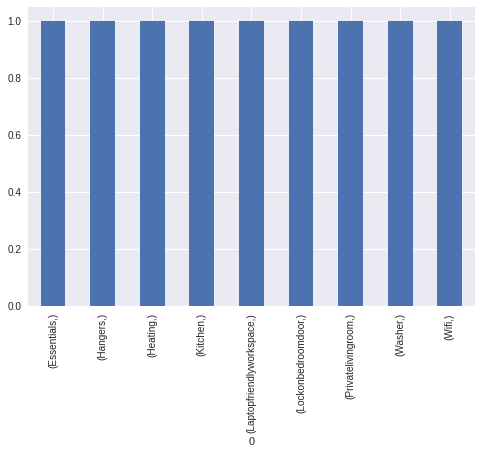

In [140]:

for i,row in df_raw.iterrows():
    amenit_list= []
    for amenit in row['amenities'].split('{')[1].split('"'):
        if len(list(amenit)) !=1:
            #amenit = amenit.replace(',',' ')
            #amenit = amenit.replace('"',' ')
            amenit = amenit.replace(' ','')
            amenit = amenit.replace('}','')
            temp_list = amenit.split(',')     
            temp_list = [i for i in temp_list if i]
            #print(temp_list)
            amenit_list.extend(temp_list)
    #print(len(amenit_list))

amenit_list = pd.DataFrame(amenit_list)
amenit_list.value_counts().head(10).plot(kind='bar')

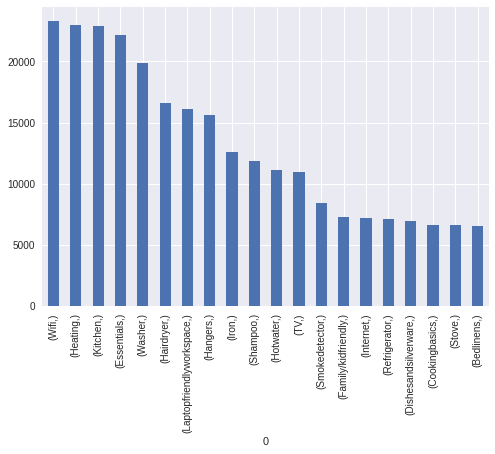

In [141]:
popular_amenities= {'Wifi','Heating','Kitchen','Essentials',
                    'Washer','Hairdryer','Laptopfriendlyworkspace',
                    'Hangers','Iron','Shampoo','Hotwater','TV','Smokedetector','Family/kidfriendly',
                    'Internet','Refrigerator','Dishesandsilverware','Cookingbasics','Stove','Bedlinens'}
amenit_list= []
for i,row in df_raw.iterrows():
    for amenit in row['amenities'].split('{')[1].split('"'):
        if len(list(amenit)) !=1:
            #amenit = amenit.replace(',',' ')
            #amenit = amenit.replace('"',' ')
            amenit = amenit.replace(' ','')
            amenit = amenit.replace('}','')
            temp_list = amenit.split(',')     
            temp_list = [i for i in temp_list if i]
            #print(temp_list)
            amenit_list.extend(temp_list)
    
amenit_list = pd.DataFrame(amenit_list)
plot = amenit_list.value_counts().head(20).plot(kind='bar')

These are all essentials things, they didn't make me satisfy. Lets remove these common amenities and find out what hosts have more to offer

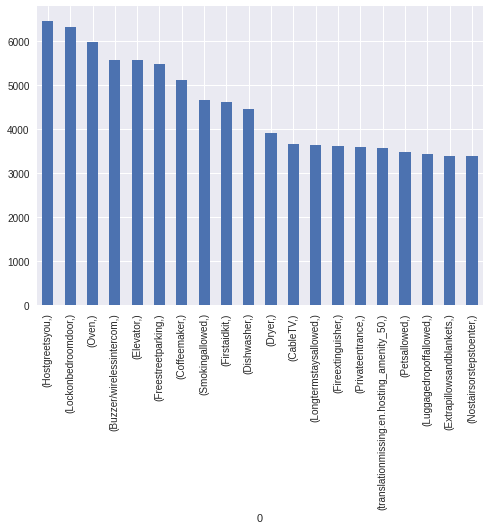

In [94]:
popular_amenities= {'Wifi','Heating','Kitchen','Essentials',
                    'Washer','Hairdryer','Laptopfriendlyworkspace',
                    'Hangers','Iron','Shampoo','Hotwater','TV','Smokedetector','Family/kidfriendly',
                    'Internet','Refrigerator','Dishesandsilverware','Cookingbasics','Stove','Bedlinens'}

all_amen = []
for i,row in df_raw.iterrows():
    amenit_list= []
    for amenit in row['amenities'].split('{')[1].split('"'):
        if len(list(amenit)) !=1:
            #amenit = amenit.replace(',',' ')
            #amenit = amenit.replace('"',' ')
            amenit = amenit.replace(' ','')
            amenit = amenit.replace('}','')
            temp_list = amenit.split(',')     
            temp_list = [i for i in temp_list if i]
            #print(temp_list)
            amenit_list.extend(temp_list)
    list1 = [ele for ele in amenit_list if ele not in popular_amenities]
    all_amen.extend(list1)
    
all_amen = pd.DataFrame(all_amen)

plot = all_amen.value_counts().head(20).plot(kind='bar')


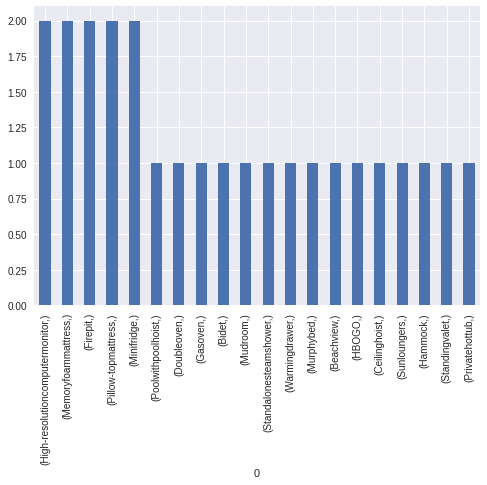

In [142]:
plot = all_amen.value_counts().tail(20).plot(kind='bar')

Well, I'm suprised there is only one private hot tub on Berlin AirBnb.

Let's see the distribution of price on Berlin's map.


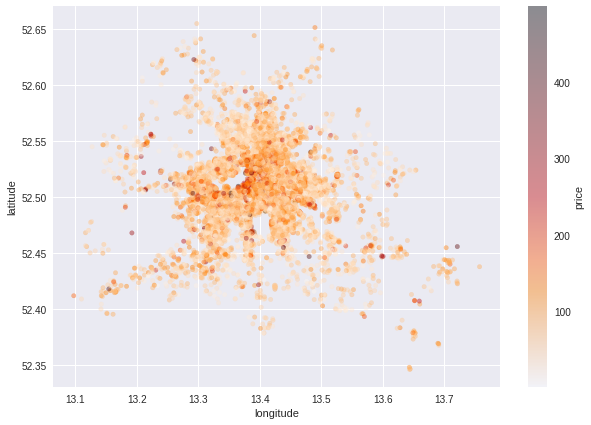

In [167]:
plot = df_raw.plot(kind="scatter",x="longitude", y="latitude", alpha=0.4, figsize=(10,7), 
        c="price", cmap="gist_heat_r", colorbar=True, sharex=False);


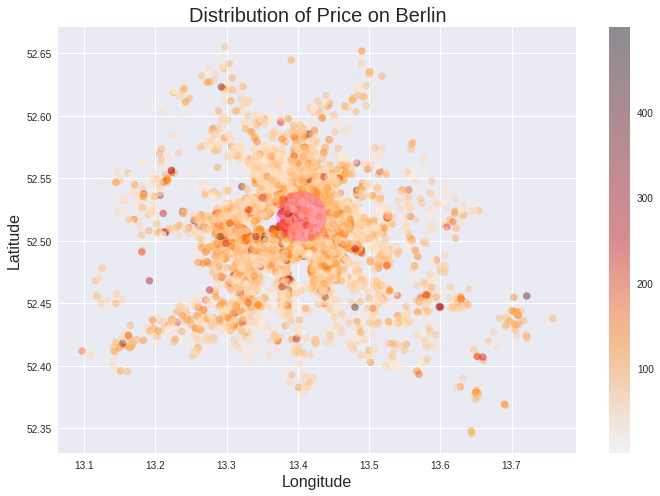

In [192]:
plt.rcParams['figure.figsize'] = [10, 7]

longitude = df_raw['longitude']
latitude = df_raw['latitude']
price = df_raw['price']

#Berlin's Center Point:
center_lat= 52.5200
center_long = 13.4050

fig, ax = plt.subplots()

im = ax.scatter(x=longitude, y=latitude, alpha=0.4,
         c=price, cmap="gist_heat_r");

ax.scatter(x= center_long, y=center_lat,s=2500, c='magenta', alpha=0.2)

fig.colorbar(im, ax=ax)
ax.set_ylabel('Latitude', fontsize=16)
ax.set_xlabel('Longitude', fontsize=16)
ax.set_title('Distribution of Price on Berlin', fontsize = 20)
fig.tight_layout()

In [76]:
[x for x in amenit_list]

[0]

In [78]:
amenit_list.value_counts()

Wifi                     23427
Heating                  23058
Kitchen                  22996
Essentials               22301
Washer                   19937
                         ...  
Standalonesteamshower        1
Doubleoven                   1
Standingvalet                1
Warmingdrawer                1
Privatehottub                1
Length: 174, dtype: int64